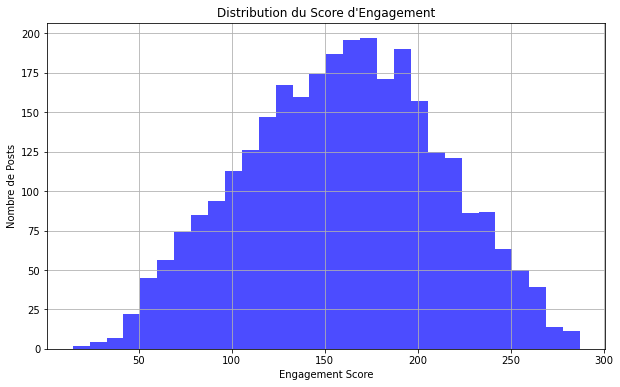

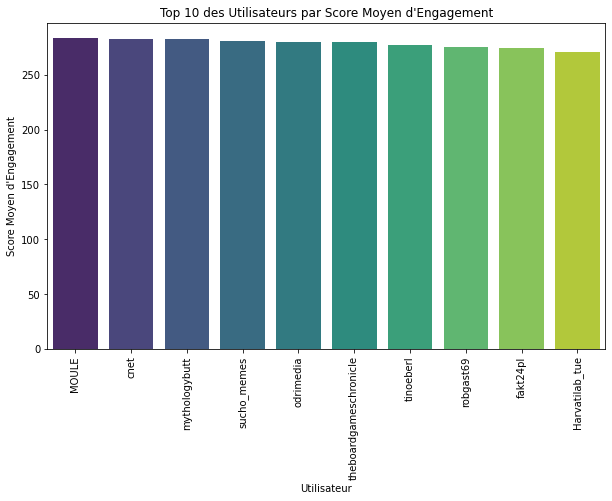

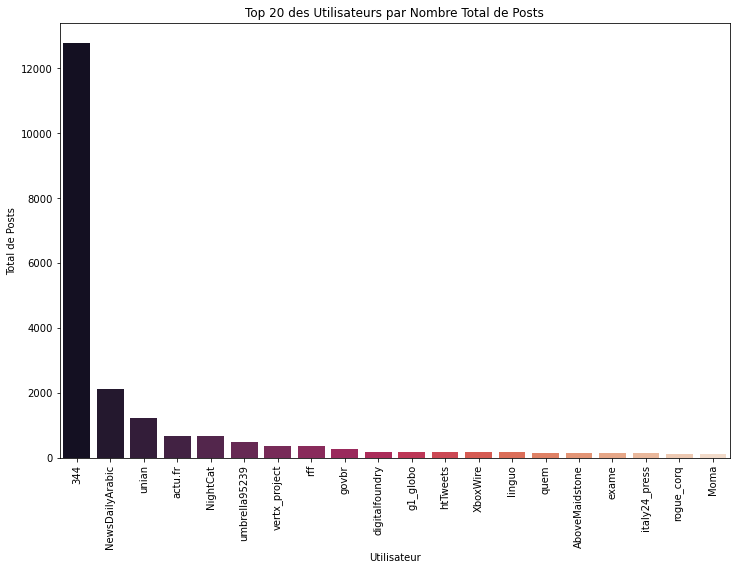

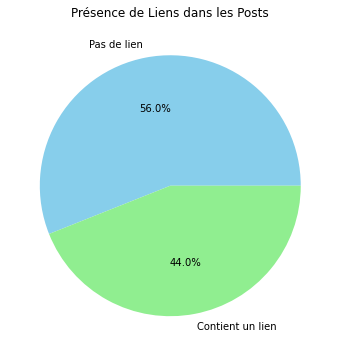

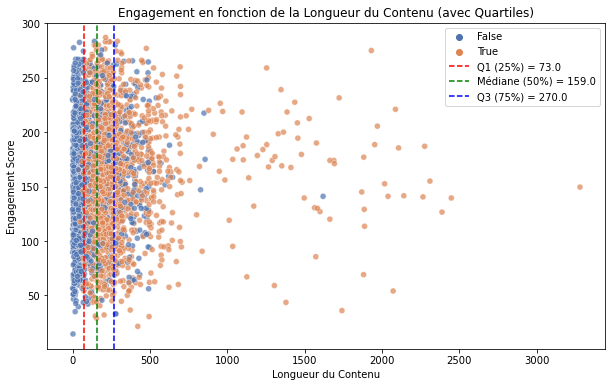

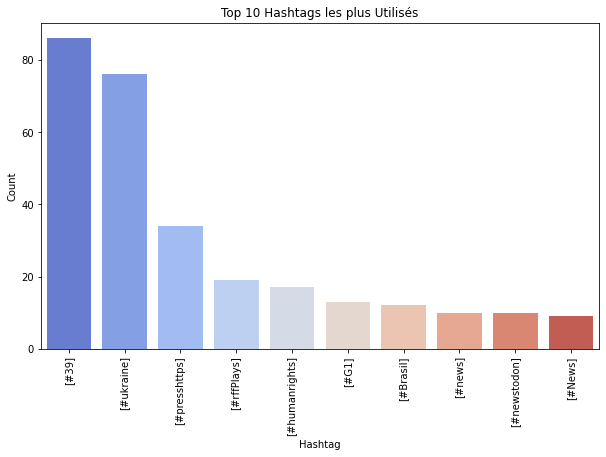

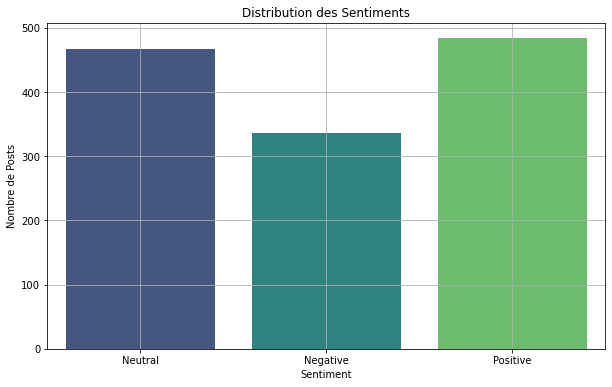

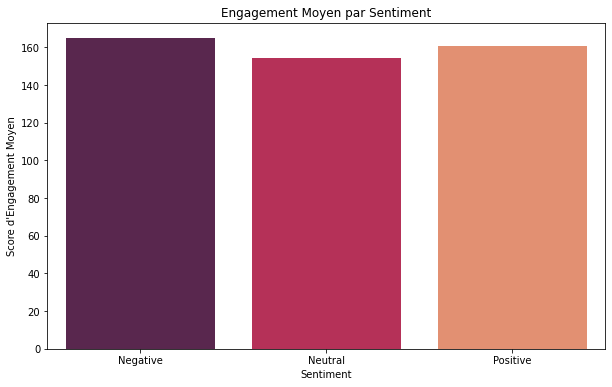

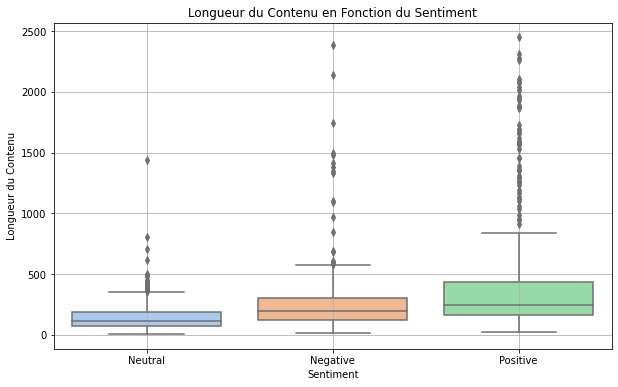

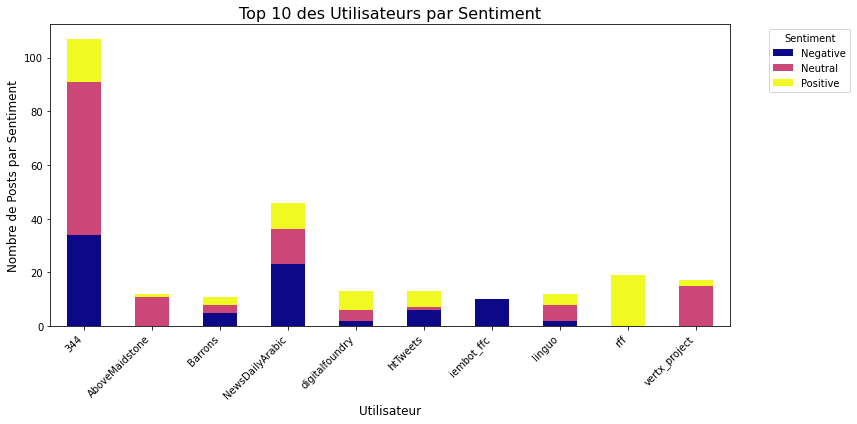

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from collections import Counter

# 1. Créer une session Spark
spark = SparkSession.builder \
    .appName("PostgresToSpark") \
    .config("spark.jars", "/usr/local/spark/jars/postgresql-42.3.9.jar") \
    .getOrCreate()

# 2. Configurer les paramètres de connexion
jdbc_url = "jdbc:postgresql://postgres:5432/DB_Mastodon"
properties = {
    "user": "fadi",       
    "password": "fadi",   
    "driver": "org.postgresql.Driver"  
}

# 3. Lire les données depuis PostgreSQL
df_gold = spark.read.jdbc(url=jdbc_url, table="Mostodon_GOLD_bis", properties=properties)
df_gold = df_gold.toPandas()  # Convertir le dataframe Spark en pandas

# 4. Visualisation 1: Distribution du score d'engagement
plt.figure(figsize=(10, 6))
plt.hist(df_gold['engagement_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution du Score d\'Engagement')
plt.xlabel('Engagement Score')
plt.ylabel('Nombre de Posts')
plt.grid(True)
plt.show()

# 5. Visualisation 2: Engagement moyen par utilisateur
df_grouped = df_gold.groupby('username')['avg_engagement_score'].mean().reset_index()
df_grouped_top10 = df_grouped.sort_values(by='avg_engagement_score', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='username', y='avg_engagement_score', data=df_grouped_top10, palette="viridis")
plt.title('Top 10 des Utilisateurs par Score Moyen d\'Engagement')
plt.xlabel('Utilisateur')
plt.ylabel('Score Moyen d\'Engagement')
plt.xticks(rotation=90)
plt.show()

# 6. Visualisation 3: Top 20 des utilisateurs par nombre total de posts
df_posts = df_gold.groupby('username')['total_posts'].sum().reset_index()
df_posts_top20 = df_posts.sort_values(by='total_posts', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='username', y='total_posts', data=df_posts_top20, palette="rocket")
plt.title('Top 20 des Utilisateurs par Nombre Total de Posts')
plt.xlabel('Utilisateur')
plt.ylabel('Total de Posts')
plt.xticks(rotation=90)
plt.show()

# 7. Visualisation 4: Présence de liens dans les posts
contains_link_counts = df_gold['contains_link'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(contains_link_counts, labels=['Pas de lien', 'Contient un lien'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Présence de Liens dans les Posts')
plt.show()

# 8. Visualisation 5: Engagement en fonction de la longueur du contenu (avec quartiles)
Q1 = df_gold['content_length'].quantile(0.25)
Q2 = df_gold['content_length'].quantile(0.50)  # Médiane
Q3 = df_gold['content_length'].quantile(0.75)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='content_length', y='engagement_score', data=df_gold, hue='contains_link', palette="deep", alpha=0.7)

# Ajout des lignes des quartiles
plt.axvline(Q1, color='red', linestyle='--', label=f'Q1 (25%) = {Q1}')
plt.axvline(Q2, color='green', linestyle='--', label=f'Médiane (50%) = {Q2}')
plt.axvline(Q3, color='blue', linestyle='--', label=f'Q3 (75%) = {Q3}')

plt.title('Engagement en fonction de la Longueur du Contenu (avec Quartiles)')
plt.xlabel('Longueur du Contenu')
plt.ylabel('Engagement Score')
plt.legend()
plt.show()

# 9. Visualisation 6: Popularité des hashtags
tags_flat = [tag for sublist in df_gold['tags'].dropna() if sublist != '[]' for tag in sublist.split(',')]
tags_count = pd.DataFrame(Counter(tags_flat).most_common(), columns=['Hashtag', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Hashtag', y='Count', data=tags_count.head(10), palette="coolwarm")
plt.title('Top 10 Hashtags les plus Utilisés')
plt.xticks(rotation=90)
plt.show()

# 10. Lire les données depuis PostgreSQL pour les sentiments
df_sentiment = spark.read.jdbc(url=jdbc_url, table="sentiment_analysis_results", properties=properties)

# 11. Convertir le dataframe PySpark en Pandas avant la fusion
df_sentiment = df_sentiment.toPandas()  # Convertir le dataframe PySpark en pandas

# 12. Joindre les deux DataFrames sur la colonne id
df_combined = df_gold.merge(df_sentiment, on='id', how='inner')

df_combined['content'] = df_combined['content_x']  

df_combined = df_combined.drop(columns=['content_x', 'content_y', 'username_y'])



# 13. S'assurer que la colonne 'content' est de type string avant d'utiliser .str
df_combined['content'] = df_combined['content'].astype(str)

# 14. Visualisation 1: Distribution des sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=df_combined, palette='viridis')
plt.title('Distribution des Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de Posts')
plt.grid(True)
plt.show()

# 15. Visualisation 2: Engagement moyen par sentiment
df_engagement = df_combined.groupby('Sentiment')['engagement_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='engagement_score', data=df_engagement, palette='rocket')
plt.title('Engagement Moyen par Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Score d\'Engagement Moyen')
plt.show()

# 16. Visualisation 3: Longueur du contenu en fonction du sentiment
df_combined['content_length'] = df_combined['content'].str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='content_length', data=df_combined, palette='pastel')
plt.title('Longueur du Contenu en Fonction du Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Longueur du Contenu')
plt.grid(True)
plt.show()

# 17. Visualisation 4: Top 10 des utilisateurs par sentiment
# Étape 1: Calculer le nombre total de posts par utilisateur pour filtrer le top 10
top_10_users = df_combined['username_x'].value_counts().nlargest(10).index

# Étape 2: Filtrer uniquement les utilisateurs du top 10
df_top10 = df_combined[df_combined['username_x'].isin(top_10_users)]

# Étape 3: Grouper par utilisateur et sentiment, puis préparer pour un graphique empilé
df_user_sentiment = df_top10.groupby(['username_x', 'Sentiment']).size().unstack().fillna(0)

# Étape 4: Créer le graphique en barres empilées
plt.figure(figsize=(12, 6))
df_user_sentiment.plot(kind='bar', stacked=True, colormap='plasma', ax=plt.gca())

# Étape 5: Ajuster les titres et étiquettes
plt.title('Top 10 des Utilisateurs par Sentiment', fontsize=16)
plt.xlabel('Utilisateur', fontsize=12)
plt.ylabel('Nombre de Posts par Sentiment', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Afficher le graphique
plt.show()


# Fermer la session Spark
spark.stop()
